**Постановка задачи**

Требуется на основании демографических данных о клиентах банка, истории их платежей и состоянии счета, предсказать невыполнение их обязательств по кредитной карте в следующем месяце.

Описание датасета

Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита

Current Credit Balance - текущий кредитный баланс

Monthly Debt - ежемесячный долг

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)



In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [2]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
PREPARED_DATASET_PATH = 'Tinyakova_predictions.csv'
SCALER_FILE_PATH = '../scaler.pkl'

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
# функция балансировки

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [5]:
# заполнение пропусков средним значением
def mean_filling(field_name):
    train_df.loc[train_df[field_name].isnull(), field_name] = train_df[field_name].mean()
    test_df.loc[test_df[field_name].isnull(), field_name] = test_df[field_name].mean()

In [6]:
# заполнение пропусков нулевым значением
def zero_filling(field_name):
    train_df.loc[train_df[field_name].isnull(), field_name] = 0
    test_df.loc[test_df[field_name].isnull(), field_name] = 0

**Загрузка данных**

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
df = pd.read_csv(TRAIN_DATASET_PATH)

**Анализ данных**

In [8]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [10]:
print("Размерность train:", train_df.shape)
print("Размерность test:", test_df.shape)

Размерность train: (7500, 17)
Размерность test: (2500, 16)


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [12]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [13]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

**Анализ целевой переменной**

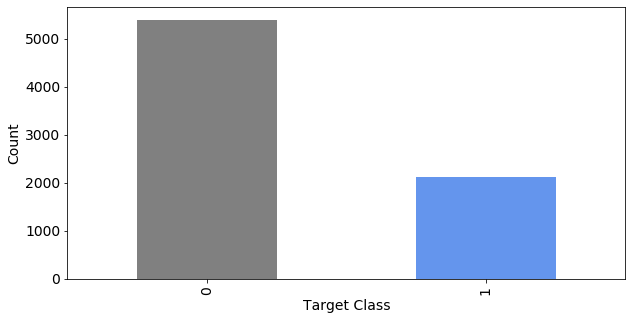

In [63]:
train_df['Credit Default'].value_counts()
train_df['Credit Default'].value_counts().plot(kind='bar', figsize=(10,5), color = ['grey', 'cornflowerblue'])
plt.xlabel('Target Class')
plt.ylabel('Count') 
plt.show()

**Анализ количественных признаков**

In [14]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
train_df_num_features.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,482087.0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,99999999.0,47386.0,7914.0,749.0,0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,264968.0,394972.0,18373.0,737.0,1
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,99999999.0,308389.0,13651.0,742.0,0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,121396.0,95855.0,11338.0,694.0,0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,125840.0,93309.0,7180.0,719.0,0


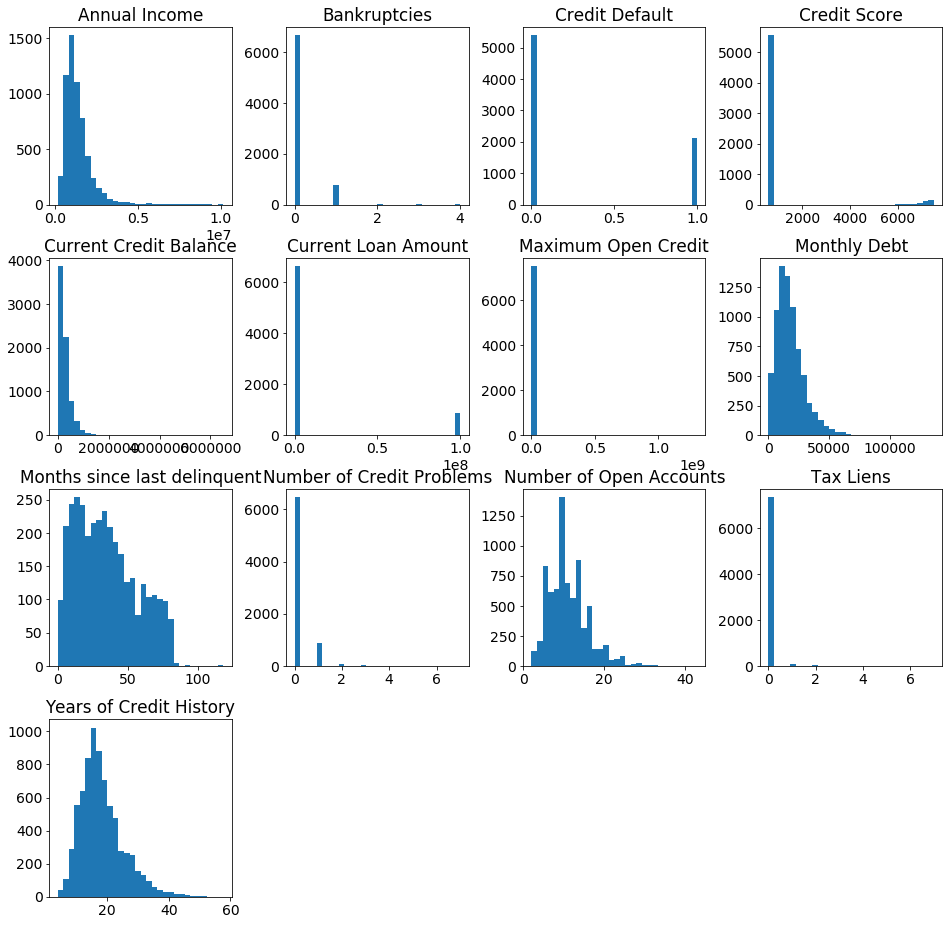

In [15]:
train_df_num_features.hist(figsize=(16,16), bins=30, grid=False);

**Обработка пропусков**

In [16]:
train_df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [17]:
# заполняем пропуски Annual Income и Credit Score средним значением
mean_filling('Annual Income')
mean_filling('Credit Score')

In [18]:
# заполняем пропуски Months since last delinquent и  Bankruptciesнулевым значением
zero_filling('Months since last delinquent')
zero_filling('Bankruptcies')

In [19]:
train_df.isnull().sum()

Home Ownership                    0
Annual Income                     0
Years in current job            371
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent      0
Bankruptcies                      0
Purpose                           0
Term                              0
Current Loan Amount               0
Current Credit Balance            0
Monthly Debt                      0
Credit Score                      0
Credit Default                    0
dtype: int64

**Преобразование категориальных данных**

In [20]:
# преобразование к строковому типу
for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    train_df[colname] = train_df[colname].astype(str)
    
for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    test_df[colname] = test_df[colname].astype(str)  

**Years in current job**

In [21]:
# замена строки на цифровое значение
years_change = {
    "Years in current job": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0
    }
}
train_df = train_df.replace(years_change)
test_df = test_df.replace(years_change)


In [22]:
test_df.loc[test_df['Years in current job'] == 'nan','Years in current job'] = 0
train_df.loc[train_df['Years in current job'] == 'nan','Years in current job'] = 0

In [23]:
test_df['Years in current job'] = test_df['Years in current job'].astype(int)
train_df['Years in current job'] = train_df['Years in current job'].astype(float)
train_df['Years in current job'] = train_df['Years in current job'].astype(int)

In [24]:
train_df.isnull().sum()



Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [25]:
train_df.dtypes


Home Ownership                   object
Annual Income                   float64
Years in current job              int32
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

**Dummies**

**Поле Home Ownership**

In [26]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [27]:
#преобразуем признак Home Ownnership в dummies
train_df = pd.concat([train_df, pd.get_dummies(train_df['Home Ownership'])], axis=1)

test_df = pd.concat([test_df, pd.get_dummies(test_df['Home Ownership'])], axis=1)

**Поле Term**

In [28]:
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [29]:
# преобразуем признак Term в бинарный
train_df['Term_bin'] = train_df['Term'].replace({'Short Term':0, 'Long Term':1})

test_df['Term_bin'] = test_df['Term'].replace({'Short Term':0, 'Long Term':1})

In [30]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job              int32
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
Have Mortgage                     uint8
Home Mortgage                     uint8
Own Home                          uint8
Rent                              uint8
Term_bin                          int64
dtype: object

**Поле Purpose**

In [31]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [32]:
test_df['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

In [33]:
# приобразуем признак Purpose в dummies
train_df = pd.concat([train_df, pd.get_dummies(train_df['Purpose'])], axis=1)

test_df = pd.concat([test_df, pd.get_dummies(test_df['Purpose'])], axis=1)

In [34]:
# Удаляем признак renewable energy, так как его нет в тестовой выборке
train_df.drop("renewable energy", axis=1, inplace=True)

**Построение новых признаков**

In [35]:
# количество проблем с кредитом в год - problem_per_year (PPY)
train_df['PPY'] = train_df['Number of Credit Problems'] / train_df['Years of Credit History']

In [36]:
test_df['PPY'] = test_df['Number of Credit Problems'] / test_df['Years of Credit History']

In [37]:
# количество денег, оставшееся "на жизнь" после выплаты ежемесячного платежа - money to live (MTL)
train_df['MTL'] = (train_df['Annual Income'] / 12) - train_df['Monthly Debt']
test_df['MTL'] = (test_df['Annual Income'] / 12) - test_df['Monthly Debt']

In [38]:
# отношение годового дохода к Current Loan Amount покажет насколько быстро может быть погашен кредит - Annual_Income_to_Current_loan
train_df['AITCL'] = train_df['Annual Income'] / train_df['Current Loan Amount']
test_df['AITCL'] = test_df['Annual Income'] / test_df['Current Loan Amount']

In [39]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job              int32
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
Have Mortgage                     uint8
Home Mortgage                     uint8
Own Home                          uint8
Rent                              uint8
Term_bin                          int64
business loan                     uint8
buy a car                         uint8
buy house                         uint8


In [40]:
train_df.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Have Mortgage',
 'Home Mortgage',
 'Own Home',
 'Rent',
 'Term_bin',
 'business loan',
 'buy a car',
 'buy house',
 'debt consolidation',
 'educational expenses',
 'home improvements',
 'major purchase',
 'medical bills',
 'moving',
 'other',
 'small business',
 'take a trip',
 'vacation',
 'wedding',
 'PPY',
 'MTL',
 'AITCL']

In [41]:
TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = [ 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'PPY',
 'MTL',
 'AITCL']
    
CAT_FEATURE_NAMES = [ 'Have Mortgage',
 'Home Mortgage',
 'Own Home',
 'Rent',
 'business loan',
 'debt consolidation',
 'home improvements',
 'major purchase',
 'medical bills',
 'other',
 'small business',
 'wedding',
 'take a trip',
 'vacation',
 'buy house',
 'buy a car',
 'moving',
 'educational expenses',
 'Term_bin']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

**Нормализация данных**

In [42]:
scaler = StandardScaler()
train_stand_features = scaler.fit_transform(train_df[NUM_FEATURE_NAMES])

In [43]:
train_stand_features= pd.DataFrame(train_stand_features, columns=NUM_FEATURE_NAMES)
other_features = train_df[CAT_FEATURE_NAMES]

In [44]:
train_stand_features.reset_index(inplace=True)
train_stand_features

,index,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,PPY,MTL,AITCL
0,0,-1.175263,-1.489549,-0.110953,-0.026674,1.133645,-0.016174,1.664779,2.545732,2.760520,-0.762772,-0.872085,-0.281552,0.946701,-1.102110,-0.874281
1,1,-0.453071,1.175372,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.337099,-0.363620,0.330781,0.004909,-0.289955,-0.321056,-0.495706,-0.253076
2,2,-0.817324,0.642388,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.337099,2.760520,0.058379,-0.391034,-0.286453,-0.321056,-0.811192,-0.873849
3,3,-0.746014,0.109404,-0.110953,-0.637847,0.593985,-0.049781,1.664779,2.545732,-0.368118,-0.610282,-0.584980,-0.320064,1.160811,-0.693055,0.190724
4,4,-0.784295,0.642388,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.337099,-0.367978,-0.618292,-0.933631,-0.302559,2.130563,-0.662448,0.116301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,7495,-1.281446,-1.489549,-0.110953,-1.656468,-1.394234,-0.052248,-0.340979,-0.337099,-0.367868,-0.680639,-1.376362,-0.317964,-0.321056,-1.113322,-0.375398
7496,7496,0.222734,-1.223057,-0.110953,-0.230398,1.162048,-0.016152,-0.340979,-0.337099,-0.358011,0.524039,-0.463816,4.382648,-0.321056,0.339514,-0.319880
7497,7497,0.681150,0.109404,-0.110953,0.177050,1.957336,0.052029,-0.340979,-0.337099,2.760520,0.591407,-0.489306,-0.282252,-0.321056,0.845329,-0.872037
7498,7498,0.000000,-1.489549,-0.110953,2.010568,1.162048,0.012237,-0.340979,-0.337099,-0.352647,0.585907,1.576689,0.000000,-0.321056,-0.327430,-0.518156


In [45]:
other_features.reset_index(inplace=True)
other_features

,index,Have Mortgage,Home Mortgage,Own Home,Rent,business loan,debt consolidation,home improvements,major purchase,medical bills,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,7495,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7496,7496,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
7497,7497,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7498,7498,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
train_df_stand=pd.merge(train_stand_features, other_features, on='index', how='inner')

In [47]:
train_df_stand.head()

,index,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,...,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,0,-1.175263,-1.489549,-0.110953,-0.026674,1.133645,-0.016174,1.664779,2.545732,2.760520,...,0,0,0,0,0,0,0,0,0,0
1,1,-0.453071,1.175372,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.337099,-0.363620,...,0,0,0,0,0,0,0,0,0,1
2,2,-0.817324,0.642388,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.337099,2.760520,...,0,0,0,0,0,0,0,0,0,0
3,3,-0.746014,0.109404,-0.110953,-0.637847,0.593985,-0.049781,1.664779,2.545732,-0.368118,...,0,0,0,0,0,0,0,0,0,0
4,4,-0.784295,0.642388,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.337099,-0.367978,...,0,0,0,0,0,0,0,0,0,0


In [48]:
train_df_stand.drop("index", axis=1, inplace=True)
train_df_stand.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,...,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,-1.175263,-1.489549,-0.110953,-0.026674,1.133645,-0.016174,1.664779,2.545732,2.760520,-0.762772,...,0,0,0,0,0,0,0,0,0,0
1,-0.453071,1.175372,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.337099,-0.363620,0.330781,...,0,0,0,0,0,0,0,0,0,1
2,-0.817324,0.642388,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.337099,2.760520,0.058379,...,0,0,0,0,0,0,0,0,0,0
3,-0.746014,0.109404,-0.110953,-0.637847,0.593985,-0.049781,1.664779,2.545732,-0.368118,-0.610282,...,0,0,0,0,0,0,0,0,0,0
4,-0.784295,0.642388,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.337099,-0.367978,-0.618292,...,0,0,0,0,0,0,0,0,0,0


**Стандартизация тестовых данных**

In [49]:
test_stand_features = scaler.transform(test_df[NUM_FEATURE_NAMES])

In [50]:
test_stand_features = pd.DataFrame(test_stand_features, columns=NUM_FEATURE_NAMES)
other_features = test_df[CAT_FEATURE_NAMES]

In [51]:
test_stand_features.reset_index(inplace=True)
test_stand_features

,index,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,PPY,MTL,AITCL
0,0,0.000704,-0.423580,-0.110953,-0.434123,-0.826171,-0.045191,-0.340979,-0.337099,-0.366831,-0.578660,-0.964404,0.058419,-0.321056,0.201046,0.477048
1,1,-1.507851,-1.223057,-0.110953,-1.045295,2.042545,-0.055488,-0.340979,-0.337099,-0.369468,-0.767016,-1.341313,-0.316563,-0.321056,-1.367802,-0.399202
2,2,-0.284214,-0.690072,-0.110953,-0.230398,-0.655753,-0.046212,-0.340979,-0.337099,-0.365650,-0.450977,0.034760,4.277614,-0.321056,-0.317539,0.050237
3,3,-0.194142,1.175372,-0.110953,0.991947,-0.187101,-0.030505,-0.340979,-0.337099,-0.365111,-0.241102,0.775161,-0.288554,-0.321056,-0.372952,0.027111
4,4,1.295215,0.109404,-0.110953,-0.026674,0.750203,0.016357,-0.340979,-0.337099,-0.347561,0.426483,2.036777,-0.311661,-0.321056,0.991208,-0.391266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2495,-0.460293,1.175372,-0.110953,0.584498,1.531289,-0.024087,1.664779,2.545732,2.760520,-0.399868,-0.274062,-0.284353,0.824718,-0.445658,-0.873417
2496,2496,0.000704,-0.956565,-0.110953,0.788223,-0.187101,0.049461,-0.340979,-0.337099,-0.357244,3.616282,1.231057,0.058419,-0.321056,-0.254884,-0.406175
2497,2497,-0.258609,-0.956565,-0.110953,7.511121,-0.783567,0.047505,-0.340979,-0.337099,-0.358435,1.216311,1.559416,-0.319364,-0.321056,-0.606206,-0.437608
2498,2498,-0.854393,1.175372,-0.110953,0.584498,1.488684,0.000039,-0.340979,-0.337099,-0.363846,0.319065,-0.403192,-0.285053,-0.321056,-0.849141,-0.423979


In [52]:
other_features.reset_index(inplace=True)
other_features

,index,Have Mortgage,Home Mortgage,Own Home,Rent,business loan,debt consolidation,home improvements,major purchase,medical bills,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2495,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2496,2496,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2497,2497,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2498,2498,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
test_df_stand=pd.merge(test_stand_features, other_features, on='index', how='inner')

In [54]:
test_df_stand.drop("index", axis=1, inplace=True)
test_df_stand.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,...,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,0.000704,-0.423580,-0.110953,-0.434123,-0.826171,-0.045191,-0.340979,-0.337099,-0.366831,-0.578660,...,0,0,0,0,0,0,0,0,0,0
1,-1.507851,-1.223057,-0.110953,-1.045295,2.042545,-0.055488,-0.340979,-0.337099,-0.369468,-0.767016,...,0,0,0,0,0,0,0,0,1,0
2,-0.284214,-0.690072,-0.110953,-0.230398,-0.655753,-0.046212,-0.340979,-0.337099,-0.365650,-0.450977,...,0,0,0,0,0,0,0,0,0,0
3,-0.194142,1.175372,-0.110953,0.991947,-0.187101,-0.030505,-0.340979,-0.337099,-0.365111,-0.241102,...,0,0,0,0,0,0,0,0,0,0
4,1.295215,0.109404,-0.110953,-0.026674,0.750203,0.016357,-0.340979,-0.337099,-0.347561,0.426483,...,0,0,0,0,0,0,0,0,0,1


**Разбиение на train и valid**

In [55]:
X = train_df_stand[SELECTED_FEATURE_NAMES]
y = train_df[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [56]:
X_test = test_df_stand[SELECTED_FEATURE_NAMES]
X_test.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,...,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,0.000704,-0.423580,-0.110953,-0.434123,-0.826171,-0.045191,-0.340979,-0.337099,-0.366831,-0.578660,...,0,0,0,0,0,0,0,0,0,0
1,-1.507851,-1.223057,-0.110953,-1.045295,2.042545,-0.055488,-0.340979,-0.337099,-0.369468,-0.767016,...,0,0,0,0,0,0,0,0,1,0
2,-0.284214,-0.690072,-0.110953,-0.230398,-0.655753,-0.046212,-0.340979,-0.337099,-0.365650,-0.450977,...,0,0,0,0,0,0,0,0,0,0
3,-0.194142,1.175372,-0.110953,0.991947,-0.187101,-0.030505,-0.340979,-0.337099,-0.365111,-0.241102,...,0,0,0,0,0,0,0,0,0,0
4,1.295215,0.109404,-0.110953,-0.026674,0.750203,0.016357,-0.340979,-0.337099,-0.347561,0.426483,...,0,0,0,0,0,0,0,0,0,1


**Балансировка целевой переменной**

In [57]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]    
df_balanced[TARGET_NAME].value_counts()

0    3795
1    2910
Name: Credit Default, dtype: int64

**Логистическая регрессия**

In [58]:
model_lr = LogisticRegression(random_state=1)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_valid_pred = model_lr.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.85      0.76      3795
           1       0.72      0.52      0.60      2910

    accuracy                           0.70      6705
   macro avg       0.71      0.68      0.68      6705
weighted avg       0.71      0.70      0.69      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1592
           1       0.56      0.51      0.53       658

    accuracy                           0.74      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1325  267
1                324  334


**К-ближайших соседей**

In [59]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_valid_pred = model_knn.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      3795
           1       0.79      0.67      0.72      2910

    accuracy                           0.78      6705
   macro avg       0.78      0.76      0.77      6705
weighted avg       0.78      0.78      0.77      6705

TEST

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1592
           1       0.46      0.49      0.48       658

    accuracy                           0.68      2250
   macro avg       0.62      0.63      0.63      2250
weighted avg       0.69      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1215  377
1                333  325


Из этих двух моделей лучшая - линейная регрессия.  xgboost, lightgbm, catboost не подключаются, Jupiter выдает ошибку. Не смогла победить.


In [60]:
y_test_pred = model_lr.predict(X_test)

In [61]:
test_df.reset_index(inplace=True)
pd.DataFrame({ 'Id': test_df['index'], 'Credit Default': y_test_pred }).to_csv(PREPARED_DATASET_PATH, index=False)

In [62]:
result = pd.read_csv(PREPARED_DATASET_PATH)
result.head()

,Id,Credit Default
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0
